In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
torch.random.manual_seed(42)
torch.cuda.manual_seed(42)
import pandas as pd
import pandas as pd
from utils import make_vocab, stoi, training_loop
from model import CustomResNet
from dataset import CocoDataset
from tqdm import tqdm, trange
from torchvision.transforms import Compose, Resize, Normalize, CenterCrop
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
image_captions_df = pd.read_parquet('F://coco/captions/image_captions_df_less_than_15.parquet')
image_captions_df

,image_id,file_name,captions,caption_token_set,idx_captions,tokens,shortest_token,shortest_token_len
0,57870,COCO_train2014_000000057870.jpg,"[[a, restaurant, has, modern, wooden, tables, ...","[arrangement, is, flower, on, table, blue, top...","[[27, 13, 25, 23, 9, 30, 12, 19], [27, 22, 13,...","[[a, restaurant, has, modern, wooden, tables, ...","[a, table, is, adorned, with, wooden, chairs, ...",11
1,384029,COCO_train2014_000000384029.jpg,"[[a, man, preparing, desserts, in, a, kitchen,...","[types, desserts, person, is, kitchen, many, u...","[[27, 53, 56, 33, 29, 27, 35, 42, 29, 50], [27...","[[a, man, preparing, desserts, in, a, kitchen,...","[close, up, of, a, hand, touching, various, pa...",9
2,222016,COCO_train2014_000000222016.jpg,"[[a, big, red, telephone, booth, that, a, man,...","[inside, person, image, standing, is, an, that...","[[27, 66, 62, 67, 65, 61, 27, 53, 1, 59, 29], ...","[[a, big, red, telephone, booth, that, a, man,...","[a, man, using, a, phone, in, a, phone, booth, .]",10
3,520950,COCO_train2014_000000520950.jpg,"[[the, kitchen, is, full, of, spices, on, the,...","[is, on, that, kitchen, all, utilizes, with, i...","[[20, 35, 1, 73, 28, 80, 3, 20, 75], [27, 35, ...","[[the, kitchen, is, full, of, spices, on, the,...","[a, very, small, kitchen, with, a, stove, and,...",12
4,69675,COCO_train2014_000000069675.jpg,"[[a, child, and, woman, are, cooking, in, the,...","[child, woman, person, on, women, an, together...","[[27, 88, 12, 89, 94, 98, 29, 20, 99], [27, 89...","[[a, child, and, woman, are, cooking, in, the,...","[two, women, cooking, on, stove, in, a, kitche...",10
...,...,...,...,...,...,...,...,...
66657,53136,COCO_train2014_000000053136.jpg,"[[vegetable, and, rice, dish, served, in, a, w...","[bed, vegetables, on, white, top, with, pasta,...","[[2753, 12, 2778, 339, 995, 29, 27, 118, 358],...","[[vegetable, and, rice, dish, served, in, a, w...","[a, white, bowl, contains, shredded, cabbage, ...",9
66658,360271,COCO_train2014_000000360271.jpg,"[[women, sitting, at, a, dinner, table, with, ...","[woman, another, dinner., sitting, is, watchin...","[[90, 215, 102, 27, 311, 4, 7, 140, 145, 102, ...","[[women, sitting, at, a, dinner, table, with, ...","[a, bunch, of, women, are, eating, at, a, table]",9
66660,444010,COCO_train2014_000000444010.jpg,"[[a, group, of, friends, sitting, down, at, a,...","[woman, jovial, sitting, table, group, togethe...","[[27, 362, 28, 2829, 215, 144, 102, 27, 4, 330...","[[a, group, of, friends, sitting, down, at, a,...","[a, jovial, older, couple, and, a, young, woma...",14
66661,565004,COCO_train2014_000000565004.jpg,"[[wine, being, poured, into, a, glass, over, a...","[another, is, on, table, wine, with, red, glas...","[[418, 319, 6776, 161, 27, 686, 139, 27, 4], [...","[[wine, being, poured, into, a, glass, over, a...","[a, wine, glass, being, filled, with, red, win...",9


In [4]:
def make_vocab(token_list):
    """ This function takes in a token list and adds the unique tokens to the vocabulary."""
    for tokens in  token_list:
        for token in tokens:
            if token in vocab_dict:
                vocab_dict[token] +=1
            else:
                vocab_dict[token] = 1
    return vocab_dict

def make_vocab_shortest(token):
    """ This function takes in a token list and adds the unique tokens to the vocabulary."""
    for word in token:
        if word in vocab_dict:
            vocab_dict[word] +=1
        else:
            vocab_dict[word] = 1
    return vocab_dict

def stoi(captions_list, chartoidx):
    """ Function to convert the string tokens to integers.
        Also adds the <start>, <end> & <unk> tokens to form the final list to be fed in the RNN
        INPUT --> list of captions with 
        OUPUT --> """
    caption_token_list = []
    for caption in captions_list:
        tokens_list = [chartoidx['<start>']] + []
        for token in caption:
            try:
                tokens_list.append(chartoidx[token])
            except:
                tokens_list.append(chartoidx['<unk>'])
        tokens_list = tokens_list + [chartoidx['<end>']]
        caption_token_list.append(tokens_list)
    return caption_token_list


def convert_shortest_token(token_list,chartoidx):
    new_token_list = [chartoidx['<start>']]
    for token in token_list:
        new_token_list = new_token_list  + [chartoidx[token]]
    new_token_list = new_token_list + [chartoidx['<end>']]
    return new_token_list

First and foremost we would have to change the way that we are making the dataset because previously we were giving all the five caption and then taking the first from them. Now we would have to give only one caption.

In [5]:
vocab_dict = {}
image_captions_df['shortest_token'].apply(lambda x : make_vocab_shortest(x))

chartoidx = {}    # create the character to index dictionary for tokens and their integer representations.
idxtochar = []    # index to char list. Useful for decoding the output from the neural net. 
for i,word in enumerate(vocab_dict.keys()):
    chartoidx[word] = i
    idxtochar.append(word)

idxtochar = idxtochar + ['<unk>','<start>','<end>','<pad>']    # add additional tokens
chartoidx.update({'<unk>':10932,                       # add addtional tokens and their corresponding numbers 
                        '<start>':10933,
                        '<end>':10934,
                        '<pad>':10935})

# Add an idx_tokens column to the dataframe to house the integer representation of the token strings.
image_captions_df['shortest_idx_tokens'] = image_captions_df['shortest_token'].apply(lambda x : convert_shortest_token(x, chartoidx))
image_captions_df

,image_id,file_name,captions,caption_token_set,idx_captions,tokens,shortest_token,shortest_token_len,shortest_idx_tokens
0,57870,COCO_train2014_000000057870.jpg,"[[a, restaurant, has, modern, wooden, tables, ...","[arrangement, is, flower, on, table, blue, top...","[[27, 13, 25, 23, 9, 30, 12, 19], [27, 22, 13,...","[[a, restaurant, has, modern, wooden, tables, ...","[a, table, is, adorned, with, wooden, chairs, ...",11,"[10933, 0, 1, 2, 3, 4, 5, 6, 4, 7, 8, 9, 10934]"
1,384029,COCO_train2014_000000384029.jpg,"[[a, man, preparing, desserts, in, a, kitchen,...","[types, desserts, person, is, kitchen, many, u...","[[27, 53, 56, 33, 29, 27, 35, 42, 29, 50], [27...","[[a, man, preparing, desserts, in, a, kitchen,...","[close, up, of, a, hand, touching, various, pa...",9,"[10933, 10, 11, 12, 0, 13, 14, 15, 16, 9, 10934]"
2,222016,COCO_train2014_000000222016.jpg,"[[a, big, red, telephone, booth, that, a, man,...","[inside, person, image, standing, is, an, that...","[[27, 66, 62, 67, 65, 61, 27, 53, 1, 59, 29], ...","[[a, big, red, telephone, booth, that, a, man,...","[a, man, using, a, phone, in, a, phone, booth, .]",10,"[10933, 0, 17, 18, 0, 19, 20, 0, 19, 21, 9, 10..."
3,520950,COCO_train2014_000000520950.jpg,"[[the, kitchen, is, full, of, spices, on, the,...","[is, on, that, kitchen, all, utilizes, with, i...","[[20, 35, 1, 73, 28, 80, 3, 20, 75], [27, 35, ...","[[the, kitchen, is, full, of, spices, on, the,...","[a, very, small, kitchen, with, a, stove, and,...",12,"[10933, 0, 22, 23, 24, 4, 0, 25, 26, 0, 27, 12..."
4,69675,COCO_train2014_000000069675.jpg,"[[a, child, and, woman, are, cooking, in, the,...","[child, woman, person, on, women, an, together...","[[27, 88, 12, 89, 94, 98, 29, 20, 99], [27, 89...","[[a, child, and, woman, are, cooking, in, the,...","[two, women, cooking, on, stove, in, a, kitche...",10,"[10933, 29, 30, 31, 32, 25, 20, 0, 24, 33, 9, ..."
...,...,...,...,...,...,...,...,...,...
66657,53136,COCO_train2014_000000053136.jpg,"[[vegetable, and, rice, dish, served, in, a, w...","[bed, vegetables, on, white, top, with, pasta,...","[[2753, 12, 2778, 339, 995, 29, 27, 118, 358],...","[[vegetable, and, rice, dish, served, in, a, w...","[a, white, bowl, contains, shredded, cabbage, ...",9,"[10933, 0, 169, 281, 1033, 2233, 1767, 26, 117..."
66658,360271,COCO_train2014_000000360271.jpg,"[[women, sitting, at, a, dinner, table, with, ...","[woman, another, dinner., sitting, is, watchin...","[[90, 215, 102, 27, 311, 4, 7, 140, 145, 102, ...","[[women, sitting, at, a, dinner, table, with, ...","[a, bunch, of, women, are, eating, at, a, table]",9,"[10933, 0, 106, 12, 30, 214, 389, 336, 0, 1, 1..."
66660,444010,COCO_train2014_000000444010.jpg,"[[a, group, of, friends, sitting, down, at, a,...","[woman, jovial, sitting, table, group, togethe...","[[27, 362, 28, 2829, 215, 144, 102, 27, 4, 330...","[[a, group, of, friends, sitting, down, at, a,...","[a, jovial, older, couple, and, a, young, woma...",14,"[10933, 0, 2839, 1195, 293, 26, 0, 72, 139, 15..."
66661,565004,COCO_train2014_000000565004.jpg,"[[wine, being, poured, into, a, glass, over, a...","[another, is, on, table, wine, with, red, glas...","[[418, 319, 6776, 161, 27, 686, 139, 27, 4], [...","[[wine, being, poured, into, a, glass, over, a...","[a, wine, glass, being, filled, with, red, win...",9,"[10933, 0, 631, 277, 108, 61, 4, 93, 631, 9, 1..."


In [6]:
class CocoDataset(Dataset):
    def __init__(self,image_label_df, val_stride = 10, is_val_set_bool = False, test_data_set =False, test_stride = 5, transforms = None):
        
        self.transfrom = transforms
        self.is_val_set_bool = is_val_set_bool
        self.val_stride = val_stride
        self.image_label_df = image_label_df.copy()
        self.test_data_set = test_data_set
        self.test_stride = test_stride

        if self.test_data_set: #If we need only a small subset of the data to work with
            self.image_label_df = self.image_label_df[::test_stride].reset_index(drop = True)

        elif self.is_val_set_bool: # If we need only the validation data then return the validation data which is a subset of total data
            assert self.val_stride > 0
            self.image_label_df = self.image_label_df[::val_stride]

        elif self.val_stride > 0:  # Else if val_stride is greater than zero then return the remaining dataframe after removing 10% of data
            self.image_label_df = self.image_label_df.drop(index = list(range(0,len(self.image_label_df),self.val_stride)))
            
        else: # else train on the full dataset
            self.image_label_df = self.image_label_df
        
    def __len__(self):
        """ This method calculates the length of your data."""
        return len(self.image_label_df)

    # Now we will introduce function which gives us an image and its corresponding labels by id
    def get_image_by_id(self, img_id = None):
        """ This function returns an image by its id and the corresponding multiple labesl in a present/no_present binary format"""
        

        folder_path = 'F://coco/train2014/train2014/'

        if img_id == None:
            raise ValueError('Must provide IMAGE ID')

        else:
            row = self.image_label_df[self.image_label_df['image_id']==img_id]
            file_name = row['file_name'].values[0]

            captions_array = torch.tensor(row['shortest_idx_tokens'][0])

            # Get the image-data from file_name
            image_array = torchvision.io.read_image(folder_path + file_name)
            image_array = (image_array/255.0).to(torch.float32)
            image_array = self.transfrom(image_array).to(torch.float32)
        
            return image_array, captions_array


    # Now we would write the code for returning the image from index and its corresponding labels. Which would be used by the train/val dataloaders
    def __getitem__(self, ndx):

        """ This function takes in an index and returns the image and the labels of the image at that index"""
        folder_path = 'F://coco/train2014/train2014/'
        
        row = self.image_label_df.iloc[ndx]
        # print(row)

        # Now get the image_id and the file_name of the image
        image_id = row['image_id']
        file_name = row['file_name']
    
        # Now get the captions array from the dataframe
        captions_array = torch.tensor(row['shortest_idx_tokens'])
        # Now get the image_data from storage
        image_array = torchvision.io.read_image(folder_path + file_name)
        image_array = (image_array/255.0).to(torch.float32)
        image_array = self.transfrom(image_array).to(torch.float32)
        # print(captions_array)
        return (image_array, captions_array, image_id)

In [7]:
manual_transforms = Compose([
                            Resize(size = (256,256)),
                            CenterCrop(size=(224,224)),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
manual_transforms

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Create the dataset and the dataloader

In [8]:

test_coco = CocoDataset(image_label_df=image_captions_df, test_data_set=True, test_stride=50, transforms=manual_transforms)

# test_coco_dataloader = DataLoader(dataset=test_coco, pin_memory = True,batch_size=1,drop_last=True)

In [9]:
test_images = CocoDataset(image_label_df = image_captions_df, test_data_set=True, test_stride=80, transforms=manual_transforms)
test_images[2]

(tensor([[[-0.4194, -0.5215, -0.3499,  ...,  0.0569,  0.0190, -0.0546],
          [-0.2803, -0.3488, -0.3995,  ...,  0.2443, -0.3111, -0.3452],
          [-0.6214,  0.0502, -0.3616,  ...,  0.0390, -0.1889,  0.1635],
          ...,
          [ 0.2360,  0.4205,  0.5730,  ...,  0.4654,  0.3614, -0.0659],
          [ 0.1195, -0.2944,  0.3056,  ..., -0.5064,  0.1997,  0.1842],
          [ 0.2686,  0.0471,  0.3231,  ..., -0.9453, -0.8082, -0.0601]],
 
         [[-0.3731, -0.3770, -0.2355,  ...,  0.0563,  0.0564,  0.0194],
          [-0.0875, -0.2351, -0.2816,  ...,  0.3123, -0.2014, -0.2679],
          [-0.4465,  0.0220, -0.3223,  ...,  0.0897, -0.0805,  0.2395],
          ...,
          [-0.0603,  0.1459,  0.2290,  ...,  0.1597,  0.0125, -0.3780],
          [-0.2493, -0.4594, -0.0641,  ..., -0.6146, -0.0675, -0.0654],
          [ 0.0457,  0.0455,  0.2447,  ..., -1.2820, -1.0236, -0.3395]],
 
         [[-1.2547, -1.1833, -1.1456,  ..., -1.1020, -1.0698, -1.0849],
          [-1.1302, -1.1799,

In [64]:
test_coco[0]

(tensor([[[ 1.9845,  2.0282,  2.1066,  ..., -1.5453, -1.4803, -1.4329],
          [ 2.0787,  2.1186,  2.1630,  ..., -1.5129, -1.5295, -1.3770],
          [ 2.1288,  2.1801,  2.2007,  ..., -1.5440, -1.5506, -1.3885],
          ...,
          [-0.8186, -0.9293, -1.2151,  ...,  1.1449,  1.2222,  1.1112],
          [-0.6762, -0.9331, -1.2721,  ...,  1.2070,  1.0772,  1.0296],
          [-0.9186, -0.8472, -1.1707,  ...,  1.1230,  0.9924,  1.0074]],
 
         [[ 1.4887,  1.5653,  1.6484,  ..., -1.5204, -1.5866, -1.5113],
          [ 1.5893,  1.6470,  1.7540,  ..., -1.5135, -1.5127, -1.5059],
          [ 1.6629,  1.7494,  1.8205,  ..., -1.5403, -1.5721, -1.5089],
          ...,
          [-1.5387, -1.5428, -1.6320,  ...,  1.4164,  1.5767,  1.4394],
          [-1.5362, -1.5023, -1.5565,  ...,  1.5152,  1.3464,  1.2955],
          [-1.3907, -1.5480, -1.5731,  ...,  1.5051,  1.3453,  1.2162]],
 
         [[ 0.9374,  0.8916,  1.0398,  ..., -1.2865, -1.2206, -1.2715],
          [ 0.9505,  0.9995,

Now we would instantiate the pretrained model for using it in our custom model

In [14]:
# image, caption, _  = test_coco[0]
# with torch.no_grad():
#     output = res_50(image.unsqueeze(0))
#     print(output.shape)

torch.Size([1, 1000])


Now we would create out custom model which uses the pretrained model

In this custom model we would use a RNN layer instead of a RNN cell. We would also use a fixed length input with a sequence lenght of 15.

In [ ]:
class CustomResNet(nn.Module):
    def __init__(self, chartoidx, idxtochar, pretrained_model = None ):
        super().__init__()



        for parameter in pretrained_model.parameters():
            parameter.requires_grad = False

        
        pretrained_model.fc = nn.Linear(2048,256)

        self.chartoidx = chartoidx
        self.idxtochar = idxtochar
        self.backbone = nn.Sequential(pretrained_model)
        # Till the previous step we have a pretrained Resnet whose weights we have frozen. Now we will define the RNN

         

        # self.embedding_matrix = torch.randn(len(chartoidx), 50, requires_grad=True) / (len(chartoidx)**0.5)
        self.embedding_matrix = nn.Embedding(len(self.chartoidx), 50)
        self.rnn = nn.RNN(input_size=15, hidden_size = 256, num_layers = 1, nonlinearity='tanh', batch_first = True)  # here we have defined the RNN layer
        self.output_layer = nn.Linear(256,len(self.chartoidx))

        # self.cross_entopy_loss = nn.CrossEntropyLoss()

    def forward(self, image, caption_list):
        out_backbone = self.backbone(image)
        # print(f"The output backbone image shape is {out_backbone.shape}")
        hidden = out_backbone.squeeze(0)
        # print(f"the hidden shape from image is {hidden.shape}")
        i = 0
        # new_char_id = char_id
        loss_word_list = []
        # current_word_id = caption_list[i]
        # target_index = caption_list[i+1]
        
        while True:
            
            if i == 0:
                current_word_id = caption_list[0]    # start at the first word i.e the <start> token
                target_index = caption_list[i+1]
            if self.idxtochar[target_index] == '<end>':
                break
            if i!=0 and i<len(caption_list)-1:
                target_index = caption_list[i+1]
            out_embedding = self.embedding_matrix(current_word_id)  # embedding_shape = (1,50)
            # print(out_embedding.shape)
            # print(out_embedding, out_embedding.requires_grad)
            # print(f"The out embedding shape is {out_embedding.shape}")
            # calculate the hidden state activation from the embedding and the previous hidden state and get the next hidden state
            hidden = self.rnn(out_embedding, hidden)   # hidden_shape = (1,1024)

            # Now dish out the output_logits of the current time step
            output_logits = self.output_layer(hidden)   # output_logits shape (1,len(vocab))
            # print(f"The shape of output logits is {output_logits.shape}")

            # # calculate the probabilities of the characters
            probs =  torch.softmax(output_logits, dim = 0)         # probs_shape = (1,len(vocab))

            # print(f"The shape of probs is {probs.shape}")
            # print(f"The shape of output probabilities is {probs.shape}")
            # # Now get the index of the larget probability.
            next_word_id = torch.argmax(probs, dim =0)
            # print(f"the next word id  is {idxtochar[next_word_id.item()]}, and id is {next_word_id.item()}")

            # Now we will take the next_word that the cell thinks will be and do two things.
            # First we use it and the target to calculate the loss
            current_word_loss = cross_entropy(probs, target_index)
            # append the current_word_loss to loss_word_list
            loss_word_list.append(current_word_loss)
            
            # Second we would use the index of the current most probable output word as an input of the next time-step
            current_word_id = next_word_id
            # increase the value of i by 1 so that we can get the target word for the next input word
            i+=1
            
        final_loss = torch.sum(torch.tensor(loss_word_list, requires_grad=True))
        return final_loss

In [16]:
from torch.nn.utils.rnn import pad_sequence

In [22]:
embedding_mat = nn.Embedding(30,10)
caption_1 = torch.tensor([4,5,6,7,8,1,2,15,16,19,25,21,5,9,17])
caption_2 = torch.tensor([1,2,3,4,5,6,7,8,8,12,10])
pad_init = pad_sequence([caption_1, caption_2],batch_first=True)
print(pad_init)

tensor([[ 4,  5,  6,  7,  8,  1,  2, 15, 16, 19, 25, 21,  5,  9, 17],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  8, 12, 10,  0,  0,  0,  0]])


In [27]:
input = embedding_mat(pad_init)
print(input.shape)

torch.Size([2, 15, 10])


In [29]:
rnn_layer = nn.RNN(input_size=10, hidden_size = 256, num_layers = 1, nonlinearity='tanh', batch_first = True)
output, h = rnn_layer(input)

In [31]:
print(rnn_layer.hidden_size)

256


In [32]:
print(rnn_layer.weight_hh_l0.shape), print(rnn_layer.weight_ih_l0.shape)

torch.Size([256, 256])
torch.Size([256, 10])


(None, None)

In [30]:
print(output.shape)
print(h.shape)

torch.Size([2, 15, 256])
torch.Size([1, 2, 256])


In [39]:
rnn = nn.RNN(10, 20, 1, batch_first = True)  # input_size = 10(10 features per input in a sequence), hidden_size = 20, num_layers = 2
input = torch.randn(3, 5, 10) # batch of 3 examples with sequence lenth of 5 and 10 features per object in the sequence
h0 = torch.randn(1, 3, 20)  # D*num_layers(1*2), batch_size = 3 , hidden_size = 20
output, hn = rnn(input, h0) 

In [40]:
print(f"The hidden weights shape is {rnn.weight_hh_l0.shape}")
print(f"The input weights shape is {rnn.weight_ih_l0.shape}")

The hidden weights shape is torch.Size([20, 20])
The input weights shape is torch.Size([20, 10])


So what happens here is that  for each input of shape (1,5,10) i.e (batch_size, sequence_length, num_features) in the batch at each time step i.e for each value in the sequence of the shape (1,1,10) it is taking in the value, then performing the calculation of multiplying the value with the input weight matrix i.e of the shape(20,10).T (according to recurrence formula) and taking the hidden_state of the pervious iteration of the shape (1,3,20) and multiplying it with the hidden state matrix to yield the shape of (1,3,20). Then after all the timesteps are over i.e when the each value of the sequence is finished then what it does is that it concatenates all the ouput of shape(1,1,20) to (3,5,20) i.e concatenates all the individual values into sequences and then all the individual sequences to batches and give out the final output of the rnn i.e the ouput of the shape of (3,5,20) and also the hidden state of the rnn i.e the hn of the shape of (1,3,20)

In [41]:
output.shape, hn.shape

(torch.Size([3, 5, 20]), torch.Size([1, 3, 20]))

But the problem that we could run here is that we could we cannot change the recurrence formula of the solution so we need to write  our own RNN layer which takes in an input sequence and the tensor from the convolution backbone and then uses it to make predictions.

In [11]:
# class ManyToManyRNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super().__init__()
#         self.rnncell = nn.RNNCell(input_size=input_size, hidden_size= hidden_size, nonlinearity='relu')
#         self.weight_hy = torch.randn(hidden_size,output_size, requires_grad=True) * 0.01

#     def forward(self, previous_state, input_tensor):
#         """ Function to process the input_captions one by one at a time and give an ouput tensor"""
#         # This line would unroll the RNN across time
#         hidden_state = self.rnncell(input_tensor, previous_state)
#         # print(f"the hidden State dim is {hidden_state.shape}")

#         output = hidden_state @ self.weight_hy

#         return (output, hidden_state)


    

#### Now lets put that into our model and try to make out custom model with the rnn piece.

In [11]:
# Lets create another custome resnet model
class CustResnetRnn(nn.Module):
    def __init__(self, chartoidx, idxtochar):
        super().__init__()

        self.chartoidx = chartoidx
        self.idxtochar = idxtochar

        self.embedding_matrix = nn.Embedding(len(self.idxtochar), 15)
        
        self.rnn_cell = nn.RNNCell(input_size=15, hidden_size= 1000, nonlinearity='tanh')

        self.fc = nn.Linear(1000, len(idxtochar))

    def forward(self, hidden_state_vector, input):
        embedding  = self.embedding_matrix(input)
        # print(f"The shape of embedding is {embedding.shape}")
        hidden_state = self.rnn_cell(embedding, hidden_state_vector)  
        # out_hidden_state = hidden_state.clone()

        rnn_output = self.fc(hidden_state)

        return rnn_output, hidden_state
    


In [71]:
# Now we will define a new training loop to
def training_loop(epochs, train_dataloader, val_dataloader, model, optimizer, res_50_model):
    """ Function to create the training loop which would take in the image and the caption train on it word by word """
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(train_dataloader):
            batch_loss = 0
            image, caption, _ = batch
            caption = caption[0]
            
            final_caption = caption[0:len(caption)-1].to(device = torch.device('cuda'))
            final_targets = caption[1:len(caption)].to(device = torch.device('cuda'))
            image = image.to(torch.device('cuda'))
            hidden_state = res_50_model(image)
            
            optimizer.zero_grad()

            # Now we would input the captions into the rnn one by one and start the generation process
            new_hidden_state = hidden_state.squeeze(0)
            
            for i in range(len(final_caption)):
                output, new_hidden_state =  model(new_hidden_state, final_caption[i])
                # target_tensor = torch.zeros(output.shape)
                
                # target_tensor[targets[i]] = 1
                # print(target_tensor.shape)
                output_logits = output.clone()
                batch_loss += F.cross_entropy(output_logits,final_targets[i])
                # print(loss)
            batch_loss = (batch_loss/len(final_caption))
            batch_loss.backward()
            optimizer.step()
            # print(batch_loss)
            # print(batch_loss)
            epoch_loss += batch_loss.item()
        print(f"The loss is {epoch_loss/len(train_dataloader)}")

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [13]:
cust_res_rnn = CustResnetRnn(chartoidx, idxtochar).to(device)

res_50 = torchvision.models.resnet50(weights =ResNet50_Weights.DEFAULT).to(device)
for parameter in res_50.parameters():
    parameter.requires_grad = False

In [78]:
adam_optimizer = optim.Adam(cust_res_rnn.parameters(), lr  = 0.00001)

In [79]:
training_loop(epochs = 10, train_dataloader=test_coco_dataloader, val_dataloader=None,
               model = cust_res_rnn, optimizer=adam_optimizer, res_50_model = res_50)

100%|██████████| 1255/1255 [01:38<00:00, 12.77it/s]


The loss is 0.08097416700802713


100%|██████████| 1255/1255 [01:38<00:00, 12.78it/s]


The loss is 0.06742731228070074


100%|██████████| 1255/1255 [01:44<00:00, 11.97it/s]


The loss is 0.06045154351370031


100%|██████████| 1255/1255 [01:45<00:00, 11.84it/s]


The loss is 0.05565560399610327


100%|██████████| 1255/1255 [01:47<00:00, 11.70it/s]


The loss is 0.05180962479513777


100%|██████████| 1255/1255 [01:47<00:00, 11.71it/s]


The loss is 0.048387199082222596


100%|██████████| 1255/1255 [01:47<00:00, 11.72it/s]


The loss is 0.045541535903777616


100%|██████████| 1255/1255 [01:47<00:00, 11.63it/s]


The loss is 0.04316263711525209


100%|██████████| 1255/1255 [01:47<00:00, 11.65it/s]


The loss is 0.04109224591597143


100%|██████████| 1255/1255 [01:47<00:00, 11.66it/s]

The loss is 0.038880217528393664


In [82]:
torch.save(cust_res_rnn.state_dict, 'working_rnn_weights.pt')

In [14]:
res_50 = torchvision.models.resnet50(weights =ResNet50_Weights.DEFAULT)
rnn_model = torch.load('working_rnn.pth').to(device = torch.device('cpu'))
rnn_model


CustResnetRnn(
  (embedding_matrix): Embedding(10936, 15)
  (rnn_cell): RNNCell(15, 1000)
  (fc): Linear(in_features=1000, out_features=10936, bias=True)
)

Now we will write the inference function to see how good responses out model generates.

In [17]:
import matplotlib.pyplot as plt

In [15]:
def inference(backbone, model, image_data,caption):
    with torch.no_grad():
        word_list = []
        hidden_backbone_vector = backbone(image_data).squeeze(0)
        start_token = torch.tensor(chartoidx['<start>'])
        in_char = start_token
        out_index = chartoidx['<start>']
        while idxtochar[out_index] != '<end>':
            rnn_output, hidden_backbone_vector = model(hidden_backbone_vector,in_char)
            out_index = torch.argmax(rnn_output)
            word_list.append(idxtochar[out_index])
            in_char = out_index
    plt.imshow(image_data.squeeze(0).permute(1,2,0).numpy())
    print(f"The correct caption is : {' '.join([idxtochar[x] for x in caption[1:]])}")
    print(f"The caption for the given image is : {' '.join(word_list)}")
            


    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The correct caption is : the miniature glass apple has a clock on it . <end>
The caption for the given image is : the miniature glass apple has a clock on it . <end>


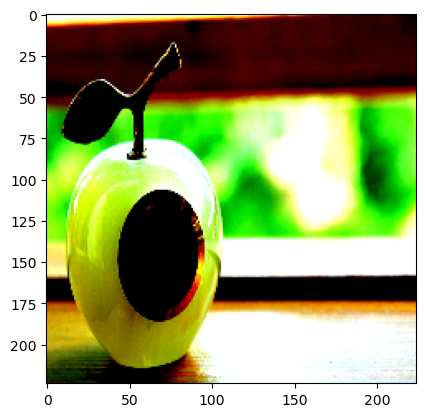

In [18]:
image, caption, _ = test_images[55]
image = image.unsqueeze(0)
inference(backbone = res_50, model = rnn_model, image_data=image, caption = caption)

#### The model above is not giving out any type of good result. This is because it has just overfitted the training set.
#### Things that we can do to improve on it are:
1. Train it on the full training set and then see if it is able to perform better.
2. Add more layers to the RNN and see the results.
3. Unfreeze the weights of the resnet and train/fine_tune the full network jointly.(This would perform better at inference)
4. One more thing that we can do here is that instead of getting the most likley character, we could just sample 5 highesst character indices   from the distribution and then at random take one and pass it as input for the next character.

In [63]:
class CustomResNet(nn.Module):
    def __init__(self, chartoidx, idxtochar, pretrained_model = None ):
        super().__init__()



        for parameter in pretrained_model.parameters():
            parameter.requires_grad = False

        
        # pretrained_model.fc = nn.Linear(2048,256)

        self.chartoidx = chartoidx
        self.idxtochar = idxtochar
        self.backbone = nn.Sequential(pretrained_model)
        # Till the previous step we have a pretrained Resnet whose weights we have frozen. Now we will define the RNN

         

        # self.embedding_matrix = torch.randn(len(chartoidx), 50, requires_grad=True) / (len(chartoidx)**0.5)
        self.embedding_matrix = nn.Embedding(len(self.idxtochar), 15)
        
        self.rnn_cell = nn.RNNCell(input_size=15, hidden_size= 256, nonlinearity='relu')
        # self.weight_hy = torch.randn(256,len(self.idxtochar), requires_grad=True) / (256**0.5)
        self.fc = nn.Linear(256, len(idxtochar))

        # self.cross_entopy_loss = nn.CrossEntropyLoss()

    def forward(self, image, caption_list):
        out_backbone = self.backbone(image)
        # print(f"The output backbone image shape is {out_backbone.shape}")
        hidden = out_backbone.squeeze(0)
        # print(f"the hidden shape from image is {hidden.shape}")
        i = 0
        # new_char_id = char_id
        loss_word_list = []
        # current_word_id = caption_list[i]
        # target_index = caption_list[i+1]
        while i<=len(caption_list):
            
            if i == 0:
                current_word_id = caption_list[0]    # start at the first word i.e the <start> token
                target_index = caption_list[1]
                target_tensor = torch.zeros(len(self.idxtochar))
                target_tensor[target_index] = 1
            if self.idxtochar[target_index] == '<end>':
                break
            if i>1 and i<=len(caption_list)-1:
                target_index = caption_list[i]
                target_tensor = torch.zeros(len(self.idxtochar))
                target_tensor[target_index] = 1
            out_embedding = self.embedding_matrix(current_word_id)  # embedding_shape = (1,50)
            # print(out_embedding.shape)
            # print(out_embedding, out_embedding.requires_grad)
            # print(f"The out embedding shape is {out_embedding.shape}")
            # calculate the hidden state activation from the embedding and the previous hidden state and get the next hidden state
            hidden = self.rnn_cell(out_embedding,hidden)   # hidden_shape = (1,1024)

            output_logits = hidden @ self.weight_hy

            # Now dish out the output_logits of the current time step
            # output_logits = self.output_layer(hidden)   # output_logits shape (1,len(vocab))
            # print(f"The shape of output logits is {output_logits.shape}")
            # return output_logits
            # # calculate the probabilities of the characters
            probs =  torch.softmax(output_logits, dim = 0)         # probs_shape = (1,len(vocab))
            # print(f"The shape of the probability tensor after softmax is {probs.shape}")
            # print(f"The shape of target_tensor is {target_tensor.shape}")

            # print(f"The shape of probs is {probs.shape}")
            # print(f"The shape of output probabilities is {probs.shape}")
            # # Now get the index of the larget probability.
            next_word_id = torch.argmax(probs, dim =0)
            # print(f"the next word id  is {idxtochar[next_word_id.item()]}, and id is {next_word_id.item()}")

            # Now we will take the next_word that the cell thinks will be and do two things.
            # First we use it and the target to calculate the loss
            current_word_loss = F.cross_entropy(probs, target_tensor)
            # append the current_word_loss to loss_word_list
            loss_word_list.append(current_word_loss)
            
            # Second we would use the index of the current most probable output word as an input of the next time-step
            current_word_id = next_word_id
            # increase the value of i by 1 so that we can get the target word for the next input word
            i+=1
            
        final_loss = torch.sum(torch.tensor(loss_word_list, requires_grad=True))
        return final_loss

In [64]:
cust_res = CustomResNet(chartoidx, idxtochar ,pretrained_model=res_50)
adam_optimizer = optim.Adam(cust_res.parameters(), lr  = 3e-2)

Now lets see how it works in training

In [65]:
def training_loop(epochs, train_dataloader, val_dataloader, model, optimizer):
    """ Function to create the training loop which would take in the image and the caption train on it word by word """
    for epoch in range(epochs):
        loss_list = []
        for batch in tqdm(train_dataloader):
            image, caption, _ = batch
            # print(image.shape)
            # image = torch.unsqueeze(image, dim=0)
            # print(caption.shape)
            # image = image.to(device = torch.device('cuda'))
            # caption = caption.to(device = torch.device('cuda'))
            optimizer.zero_grad()
            output =  model(image, caption[0])
            return output
            # print(output, grad_info)
            # break
            loss_list.append(output.item())
            output.backward()
            # print(grad_b)
            optimizer.step()
            # print(output.item())
        print(f"The loss is {sum(loss_list)/len(loss_list)}")

In [66]:
output = training_loop(10, train_dataloader=test_coco_dataloader, val_dataloader=None, model = cust_res, optimizer=adam_optimizer)

  0%|          | 0/1255 [00:00<?, ?it/s]


In [67]:
output.shape

torch.Size([10936])

In [68]:
output

tensor([ 0.1193, -0.0898,  0.1448,  ..., -0.1235, -0.0498, -0.1927],
       grad_fn=<SqueezeBackward3>)

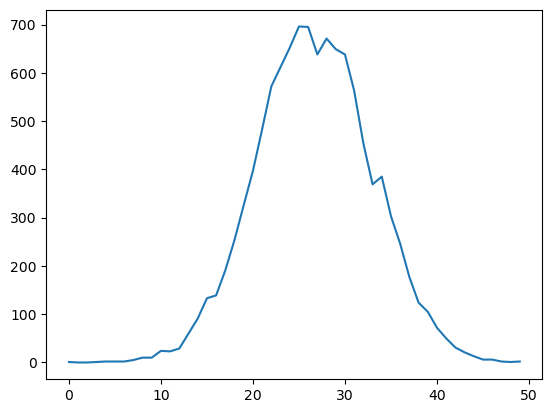

In [76]:
values, bins  = torch.histogram(output.detach(), bins = 50)
plt.plot(values)

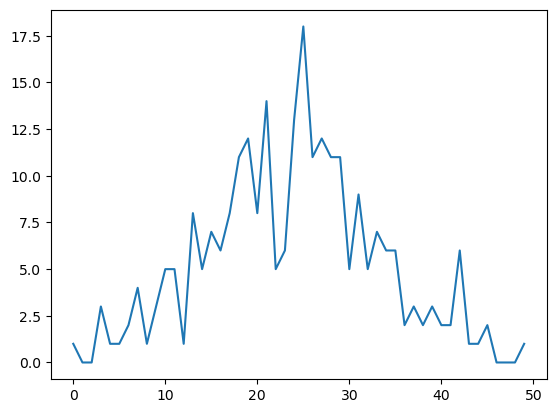

In [49]:
import matplotlib.pyplot as plt
# plt.plot(torch.histogram(out.detach().numpy(), bins=50))
values, bins = torch.histogram(out.detach(), bins=50)
plt.plot(values)
# values, bins


In [19]:
-torch.tensor(1/10937).log()

tensor(9.2999)